<a href="https://colab.research.google.com/github/mehang/Improvised-CNN/blob/master/notebook/Caltech-256-128/resized/15*15/caltech256_15_15_Gabor_Same_128.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pathlib
import time

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [3]:
!unzip /content/drive/My\ Drive/Mehang\ Rai/caltech-256-image-aspect-preserved-128.zip -d caltech-256-image-aspect-preserved-128

Streaming output truncated to the last 5000 lines.
  inflating: caltech-256-image-aspect-preserved-128/caltech-256-image-aspect-preserved/airplanes-101.251_0001.jpg  
  inflating: caltech-256-image-aspect-preserved-128/caltech-256-image-aspect-preserved/airplanes-101.251_0248.jpg  
  inflating: caltech-256-image-aspect-preserved-128/caltech-256-image-aspect-preserved/airplanes-101.251_0644.jpg  
  inflating: caltech-256-image-aspect-preserved-128/caltech-256-image-aspect-preserved/airplanes-101.251_0768.jpg  
  inflating: caltech-256-image-aspect-preserved-128/caltech-256-image-aspect-preserved/airplanes-101.251_0404.jpg  
  inflating: caltech-256-image-aspect-preserved-128/caltech-256-image-aspect-preserved/airplanes-101.251_0303.jpg  
  inflating: caltech-256-image-aspect-preserved-128/caltech-256-image-aspect-preserved/airplanes-101.251_0109.jpg  
  inflating: caltech-256-image-aspect-preserved-128/caltech-256-image-aspect-preserved/airplanes-101.251_0122.jpg  
  inflating: caltech-

In [4]:
ITERATION = 1
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3
RANDOM_SEED = [42,42,34,56,62,74,29,15,7,81][ITERATION-1]
BATCH_SIZE = 32
NUM_CLASSES = 257
EPOCHS = 1000
GABOR_LAYER_INDEX = 0
GABOR_WIDTH = 15
GABOR_HEIGHT = 15
GABOR_SIZE = (GABOR_WIDTH, GABOR_HEIGHT)
NUM_RECEPTIVE_FILTERS = 32
DATA_DIRECTORY = "caltech-256-image-aspect-preserved-128/caltech-256-image-aspect-preserved/"

In [5]:
filenames = os.listdir(DATA_DIRECTORY)
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    categories.append(category)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [6]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=RANDOM_SEED)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

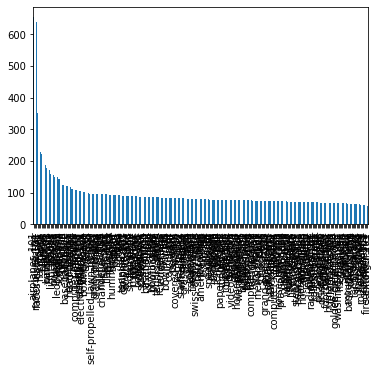

In [7]:
train_df['category'].value_counts().plot.bar()

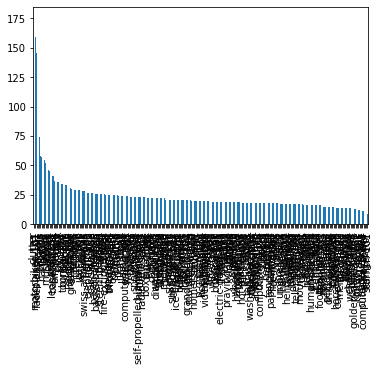

In [8]:
validate_df['category'].value_counts().plot.bar()

In [9]:
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    rescale=1./255,
)
train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    DATA_DIRECTORY, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE
)

Found 24485 validated image filenames belonging to 257 classes.


In [10]:
validation_datagen = ImageDataGenerator(
    fill_mode='nearest',
    rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    DATA_DIRECTORY, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE
)

Found 6122 validated image filenames belonging to 257 classes.


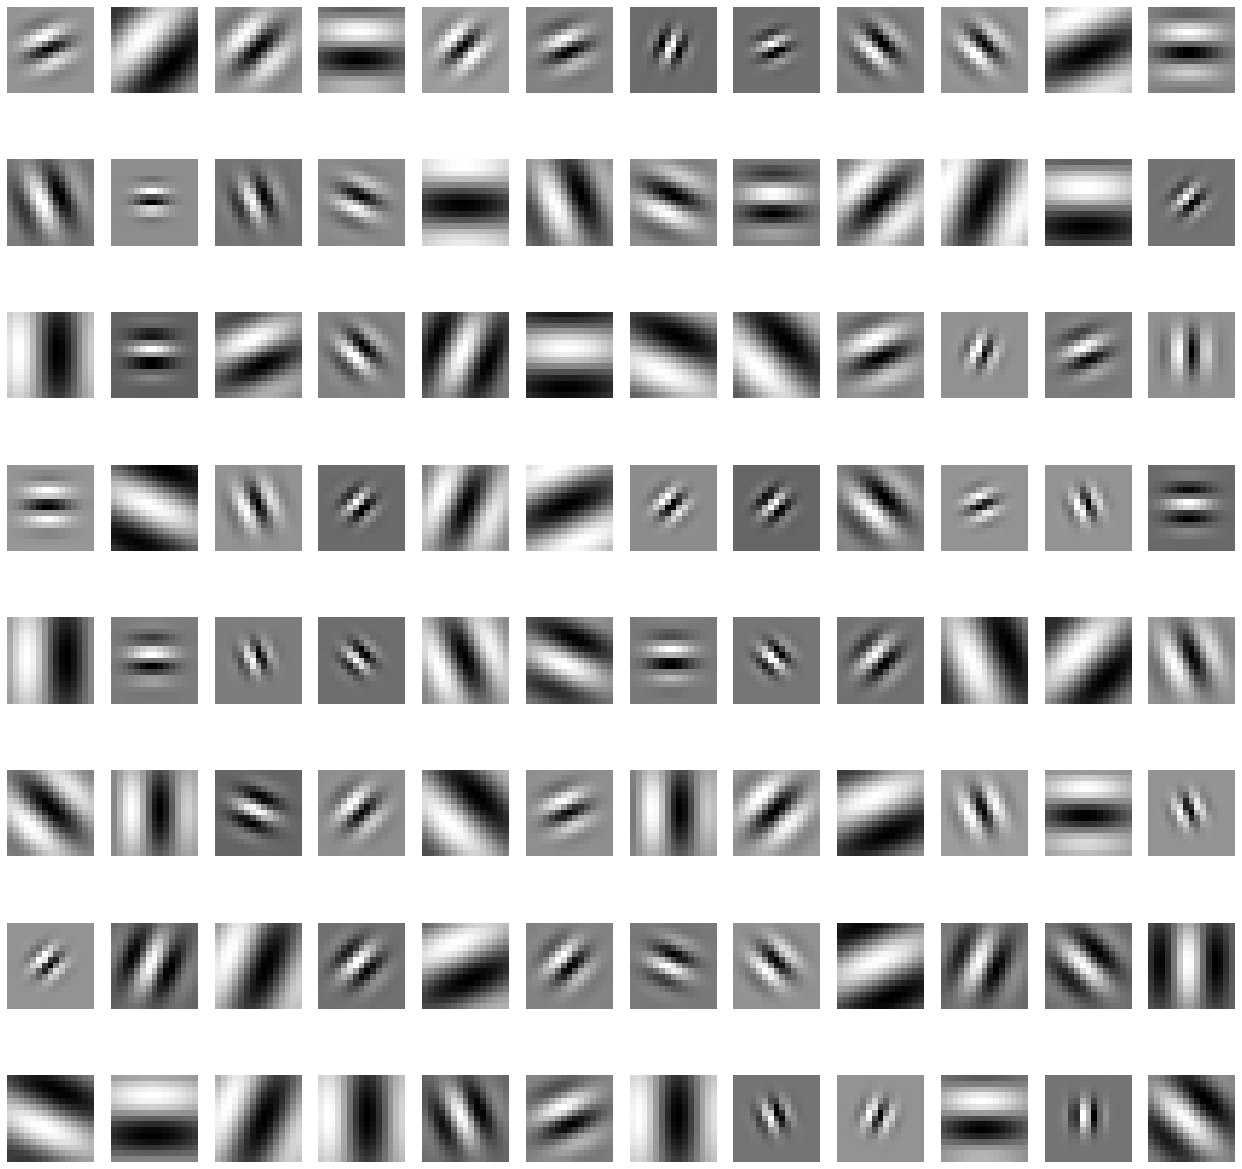

In [11]:
import math

def get_gabor_filters(inchannels, outchannels, kernel_size = (3,3)):
    delta = 1e-4
    freqs = (math.pi/2)*(math.sqrt(2)**(-np.random.randint(0,5, (outchannels, inchannels))))
    thetas = (math.pi/8)*np.random.randint(0,8, (outchannels, inchannels))
    sigmas = math.pi/(freqs)
    psis = math.pi * np.random.rand(outchannels, inchannels)
    x0, y0 = np.ceil(np.array(kernel_size)/2)    
    
    y, x = np.meshgrid(
            np.linspace(-x0 + 1, x0 + 0, kernel_size[0]),
            np.linspace(-y0 + 1, y0 + 0, kernel_size[1]),
    )
    filterbank = []
    
    for i in range(outchannels):
        for j in range(inchannels):
            freq = freqs[i][j]
            theta = thetas[i][j]
            sigma = sigmas[i][j]
            psi = psis[i][j]
            
            rotx = x * np.cos(theta) + y * np.sin(theta)
            roty = -x * np.sin(theta) + y * np.cos(theta)

            g = np.exp(
                -0.5 * ((rotx ** 2 + roty ** 2) / (sigma + delta) ** 2)
            )
            g = g * np.cos(freq * rotx + psi)
#             g = g / (2 * math.pi * (sigma ** 2))
#             g = gabor_kernel(frequency=freq, bandwidth=sigma, theta=theta, offset=psi, n_stds=0).real
            filterbank.append(g)
    return filterbank

filterbank = get_gabor_filters(3, NUM_RECEPTIVE_FILTERS, GABOR_SIZE)

fig = plt.subplots(8, len(filterbank)//8, figsize=(22,22))
for i,gf in enumerate(filterbank):
    plt.subplot(8, len(filterbank)//8, i+1)
    plt.imshow(gf, cmap='gray')
    plt.axis('off')

In [12]:
# Importing the Keras libraries and packages
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Activation
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# classifier = None
# classifier = Sequential([
#     layers.Conv2D(NUM_RECEPTIVE_FILTERS, kernel_size=GABOR_SIZE, strides=(1,1), padding='same', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3)),
#     layers.BatchNormalization(),
#     layers.Activation('relu'),
#     layers.MaxPooling2D(pool_size=(2,2)),
#     layers.Conv2D(64, kernel_size=(3,3), padding='same', strides=(1,1)),
#     layers.BatchNormalization(),
#     layers.Activation('relu'),
#     layers.MaxPooling2D(pool_size=(2,2)),
#     layers.Conv2D(128, kernel_size=(3,3), padding='same', strides=(1,1)),
#     layers.BatchNormalization(),
#     layers.Activation('relu'),
#     layers.MaxPooling2D(pool_size=(2,2)),
#     layers.Conv2D(256, kernel_size=(3,3), padding='same', strides=(1,1)),
#     layers.BatchNormalization(),
#     layers.Activation('relu'),
#     layers.MaxPooling2D(pool_size=(2,2)),
#     layers.Flatten(),
#     layers.Dense(512),
#     layers.BatchNormalization(),
#     layers.Activation('relu'),
#     layers.Dense(NUM_CLASSES, activation='softmax')
# ])

# classifier = None
# classifier = Sequential([
#     layers.Conv2D(NUM_RECEPTIVE_FILTERS, kernel_size=GABOR_SIZE, strides=(1,1), padding='same', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3)),
#     layers.BatchNormalization(),
#     layers.Activation('relu'),
#     layers.MaxPooling2D(pool_size=(2,2)),
#     layers.Dropout(0.01),
#     layers.Conv2D(64, kernel_size=(3,3), padding='same', strides=(1,1)),
#     layers.BatchNormalization(),
#     layers.Activation('relu'),
#     layers.MaxPooling2D(pool_size=(2,2)),
#     layers.Dropout(0.01),
#     layers.Conv2D(128, kernel_size=(3,3), padding='same', strides=(1,1)),
#     layers.BatchNormalization(),
#     layers.Activation('relu'),
#     layers.MaxPooling2D(pool_size=(2,2)),
#     layers.Dropout(0.01),
#     layers.Conv2D(256, kernel_size=(3,3), padding='same', strides=(1,1)),
#     layers.BatchNormalization(),
#     layers.Activation('relu'),
#     layers.MaxPooling2D(pool_size=(2,2)),
#     layers.Flatten(),
#     layers.Dropout(0.01),
#     layers.Dense(512),
#     layers.BatchNormalization(),
#     layers.Activation('relu'),
#     layers.Dense(NUM_CLASSES, activation='softmax')
# ])

classifier = None
classifier = Sequential([
    layers.Conv2D(NUM_RECEPTIVE_FILTERS, kernel_size=GABOR_SIZE, strides=(1,1), padding='same', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Dropout(0.2),
    layers.Conv2D(64, kernel_size=(3,3), padding='same', strides=(1,1)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Dropout(0.1),
    layers.Conv2D(128, kernel_size=(3,3), padding='same', strides=(1,1)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Dropout(0.1),
    layers.Conv2D(256, kernel_size=(3,3), padding='same', strides=(1,1)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Flatten(),
    layers.Dropout(0.1),
    layers.Dense(512),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

classifier.summary()

import copy
untrained_layers = copy.deepcopy(classifier.get_layer(name=classifier.layers[GABOR_LAYER_INDEX].name).get_weights())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      21632     
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 32)      128       
_________________________________________________________________
activation (Activation)      (None, 128, 128, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 64)        2

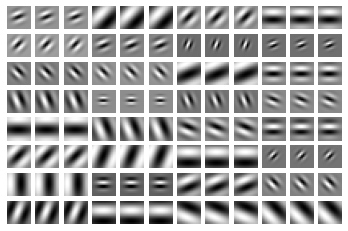

In [13]:
cnnl1 = classifier.layers[GABOR_LAYER_INDEX].name   # get the name of the first conv layer
W = classifier.get_layer(name=cnnl1).get_weights()[0]   #get the filters
wshape = W.shape  #save the original shape
gabor_filters = W
for kernel_index in range(wshape[3]):
    for channel_index in range(3):
        gabor_filters[:,:,channel_index, kernel_index] = filterbank[kernel_index]

classifier.get_layer(name=cnnl1).set_weights([gabor_filters, classifier.get_layer(name=cnnl1).get_weights()[1]])
filter_layers = []
for i in range(NUM_RECEPTIVE_FILTERS):
    for j in range(3):
        filter_layers.append(np.reshape(W[:,:,j, i], GABOR_SIZE))
for i,gf in enumerate(filter_layers):
    plt.subplot(8, len(filter_layers)//8, i+1)
    plt.imshow(gf, cmap='gray')
    plt.axis('off')
plt.savefig('caltech256-{}-initial-gabor-same-kernel-{}.png'.format(ITERATION,GABOR_WIDTH), dpi=350, bbox_inches='tight')

import copy
untrained_layers = copy.deepcopy(classifier.get_layer(name=classifier.layers[GABOR_LAYER_INDEX].name).get_weights())

In [15]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10,  
                              min_delta=1e-4, mode='min', verbose=1)
stop_alg = EarlyStopping(monitor='val_loss', patience=35, 
                         restore_best_weights=True, verbose=1)
callbacks = [stop_alg, reduce_lr]
opt = Adam(learning_rate=0.001)
classifier.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', 'AUC'])

start = time.perf_counter()
hist = classifier.fit(
    train_generator, 
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=total_validate//BATCH_SIZE,
    steps_per_epoch=total_train//BATCH_SIZE,
    callbacks=callbacks
)
finish = time.perf_counter()

Epoch 1/1000
765/765 [==============================] - 106s 138ms/step - loss: 1.5720 - accuracy: 0.5938 - auc: 0.9686 - val_loss: 4.1989 - val_accuracy: 0.3010 - val_auc: 0.8180
Epoch 2/1000
765/765 [==============================] - 105s 137ms/step - loss: 1.5677 - accuracy: 0.5941 - auc: 0.9712 - val_loss: 5.4196 - val_accuracy: 0.2268 - val_auc: 0.7638
Epoch 3/1000
765/765 [==============================] - 105s 137ms/step - loss: 1.5918 - accuracy: 0.5856 - auc: 0.9687 - val_loss: 5.7087 - val_accuracy: 0.2048 - val_auc: 0.7409
Epoch 4/1000
765/765 [==============================] - 105s 137ms/step - loss: 1.5792 - accuracy: 0.5941 - auc: 0.9717 - val_loss: 4.1732 - val_accuracy: 0.3087 - val_auc: 0.8220
Epoch 5/1000
765/765 [==============================] - 105s 137ms/step - loss: 1.5555 - accuracy: 0.5994 - auc: 0.9717 - val_loss: 4.3128 - val_accuracy: 0.3082 - val_auc: 0.8118
Epoch 6/1000
765/765 [==============================] - 105s 137ms/step - loss: 1.5675 - accuracy: 0

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10,  
                              min_delta=1e-4, mode='min', verbose=1)
stop_alg = EarlyStopping(monitor='val_loss', patience=35, 
                         restore_best_weights=True, verbose=1)
callbacks = [stop_alg, reduce_lr]
opt = Adam(learning_rate=0.001)
classifier.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', 'AUC'])

start = time.perf_counter()
hist = classifier.fit(
    train_generator, 
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=total_validate//BATCH_SIZE,
    steps_per_epoch=total_train//BATCH_SIZE,
    callbacks=callbacks
)
finish = time.perf_counter()

Epoch 1/1000
765/765 [==============================] - 127s 159ms/step - loss: 5.2992 - accuracy: 0.0738 - auc: 0.6447 - val_loss: 4.8222 - val_accuracy: 0.1027 - val_auc: 0.7364
Epoch 2/1000
765/765 [==============================] - 116s 152ms/step - loss: 4.4140 - accuracy: 0.1381 - auc: 0.7817 - val_loss: 5.0379 - val_accuracy: 0.0769 - val_auc: 0.7159
Epoch 3/1000
765/765 [==============================] - 115s 151ms/step - loss: 4.0083 - accuracy: 0.1869 - auc: 0.8310 - val_loss: 4.4707 - val_accuracy: 0.1397 - val_auc: 0.7829
Epoch 4/1000
765/765 [==============================] - 117s 152ms/step - loss: 3.7906 - accuracy: 0.2210 - auc: 0.8518 - val_loss: 4.2448 - val_accuracy: 0.1634 - val_auc: 0.8030
Epoch 5/1000
765/765 [==============================] - 117s 152ms/step - loss: 3.5963 - accuracy: 0.2445 - auc: 0.8678 - val_loss: 3.7366 - val_accuracy: 0.2271 - val_auc: 0.8482
Epoch 6/1000
765/765 [==============================] - 118s 154ms/step - loss: 3.4067 - accuracy: 0

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10,  
                              min_delta=1e-4, mode='min', verbose=1)
stop_alg = EarlyStopping(monitor='val_loss', patience=35, 
                         restore_best_weights=True, verbose=1)
callbacks = [stop_alg, reduce_lr]
opt = Adam(learning_rate=0.001)
classifier.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', 'AUC'])

start = time.perf_counter()
hist = classifier.fit(
    train_generator, 
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=total_validate//BATCH_SIZE,
    steps_per_epoch=total_train//BATCH_SIZE,
    callbacks=callbacks
)
finish = time.perf_counter()

Epoch 1/1000
765/765 [==============================] - 128s 161ms/step - loss: 5.2744 - accuracy: 0.0751 - auc: 0.6480 - val_loss: 5.8726 - val_accuracy: 0.0674 - val_auc: 0.6406
Epoch 2/1000
765/765 [==============================] - 122s 160ms/step - loss: 4.3651 - accuracy: 0.1456 - auc: 0.7880 - val_loss: 4.2665 - val_accuracy: 0.1567 - val_auc: 0.8059
Epoch 3/1000
765/765 [==============================] - 122s 159ms/step - loss: 3.9988 - accuracy: 0.1912 - auc: 0.8314 - val_loss: 3.7760 - val_accuracy: 0.2318 - val_auc: 0.8427
Epoch 4/1000
765/765 [==============================] - 122s 159ms/step - loss: 3.7807 - accuracy: 0.2157 - auc: 0.8516 - val_loss: 3.6417 - val_accuracy: 0.2426 - val_auc: 0.8535
Epoch 5/1000
765/765 [==============================] - 122s 159ms/step - loss: 3.5470 - accuracy: 0.2565 - auc: 0.8695 - val_loss: 3.7294 - val_accuracy: 0.2503 - val_auc: 0.8421
Epoch 6/1000
765/765 [==============================] - 121s 158ms/step - loss: 3.4199 - accuracy: 0

In [ ]:
print("Start time = {}".format(start))
print("Finish time = {}".format(finish))
print("Training time = {}".format(finish-start))
hist.history['start_time'] = start
hist.history['finish_time'] = finish
hist.history['train_time'] = finish-start

Start time = 378.000445283
Finish time = 8478.208855302
Training time = 8100.208410019


In [ ]:
import pickle

trained_layers = copy.deepcopy(classifier.get_layer(name=classifier.layers[GABOR_LAYER_INDEX].name).get_weights())
hist.history['untrained_layers'] = untrained_layers
hist.history['trained_layers'] = trained_layers

with open('caltech256-{}-history-gabor-same-kernel-{}.p'.format(ITERATION, GABOR_HEIGHT), 'wb') as fp:
  pickle.dump(hist.history, fp, protocol=pickle.HIGHEST_PROTOCOL)

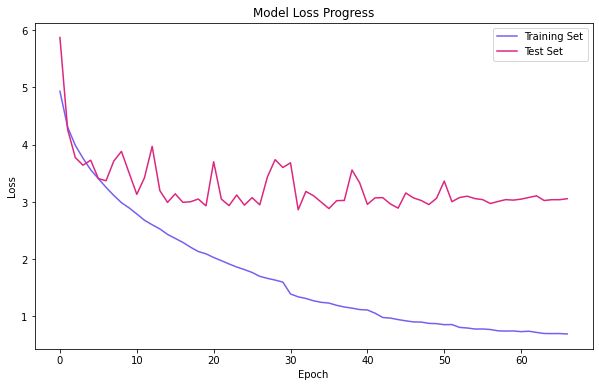

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,6))
plt.plot(hist.history['loss'], color='#785ef0')
plt.plot(hist.history['val_loss'], color='#dc267f')
plt.title('Model Loss Progress')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Set', 'Test Set'], loc='upper right')
plt.savefig('caltech256-{}-loss-gabor-same-kernel-{}.png'.format(ITERATION, GABOR_WIDTH), dpi=350, bbox_inches='tight')
plt.show()

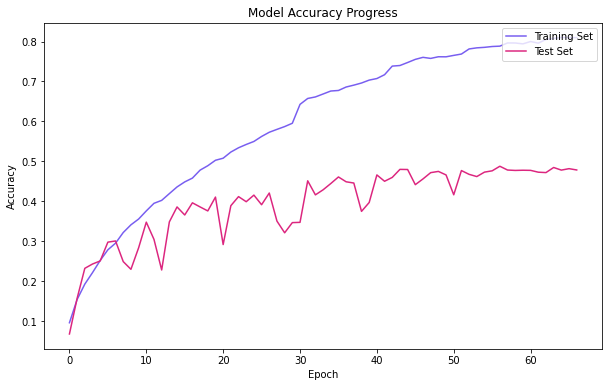

In [ ]:
fig = plt.figure(figsize=(10,6))
plt.plot(hist.history['accuracy'], color='#785ef0')
plt.plot(hist.history['val_accuracy'], color='#dc267f')
plt.title('Model Accuracy Progress')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Set', 'Test Set'], loc='upper right')
plt.savefig('caltech256-{}-accuracy-gabor-same-kernel-{}.png'.format(ITERATION, GABOR_WIDTH), dpi=350, bbox_inches='tight')
plt.show()

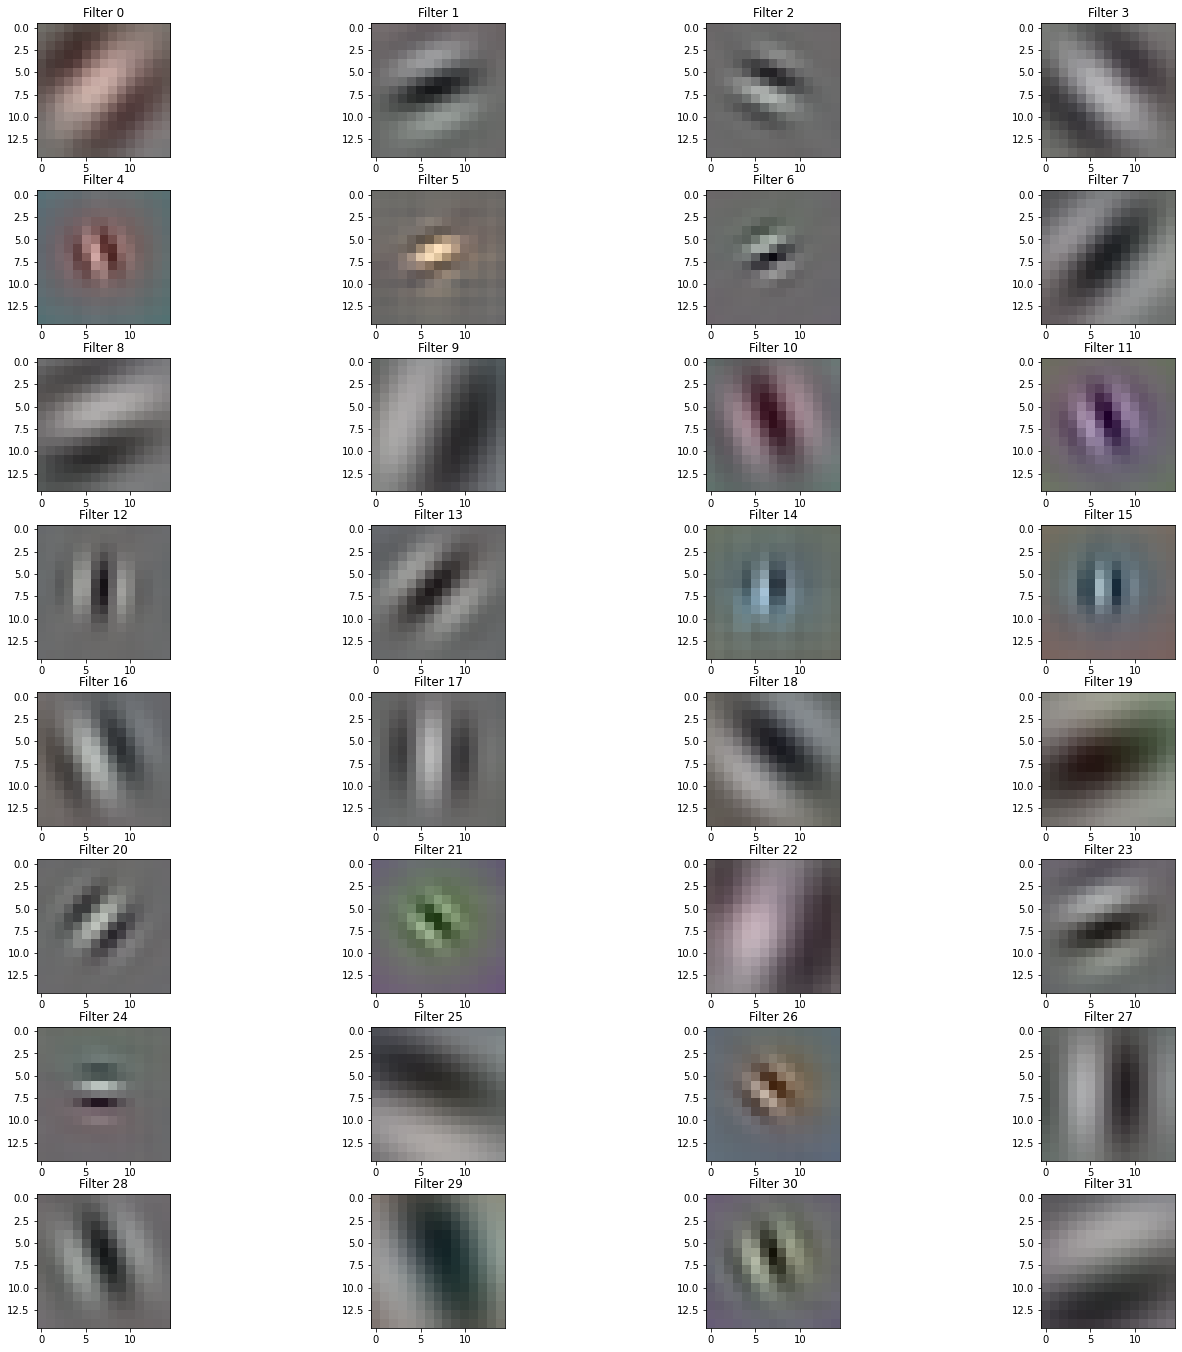

In [ ]:
from sklearn.preprocessing import MinMaxScaler

cnnl1 = classifier.layers[GABOR_LAYER_INDEX].name   # get the name of the first conv layer
W = classifier.get_layer(name=cnnl1).get_weights()[0]   #get the filters
wshape = W.shape  #save the original shape

# this part will scale to [0, 1] for visualization purposes
scaler = MinMaxScaler()
scaler.fit(W.reshape(-1,1))
W = scaler.transform(W.reshape(-1,1))
W = W.reshape(wshape)

fig, axs = plt.subplots(8,NUM_RECEPTIVE_FILTERS//8, figsize=(24,24))
fig.subplots_adjust(hspace = .25, wspace=.001)
axs = axs.ravel()
for i in range(W.shape[-1]):
  # we reshape to a 3D (RGB) image shape and display
  h = np.reshape(W[:,:,:,i], (GABOR_WIDTH,GABOR_HEIGHT,3))
  axs[i].imshow(h)
  axs[i].set_title('Filter ' + str(i))    
plt.savefig("caltech256-{}-filters-gabor-same-kernel-{}.png".format(ITERATION, GABOR_WIDTH), bbox_inches='tight', dpi=350)

-1.5205812 2.1391292


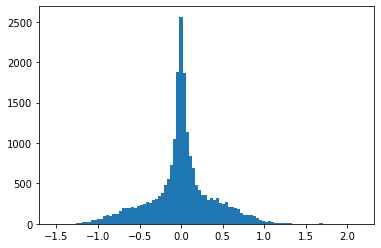

In [ ]:
cnnl1 = classifier.layers[GABOR_LAYER_INDEX].name   # get the name of the first conv layer
W = classifier.get_layer(name=cnnl1).get_weights()[0]
plt.hist(W.ravel(), bins=100)
print(np.min(W),np.max(W))

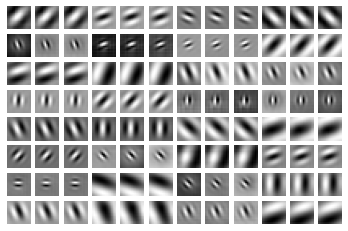

In [ ]:
filter_layers = []
for i in range(NUM_RECEPTIVE_FILTERS):
    for j in range(3):
        filter_layers.append(np.reshape(W[:,:,j, i], GABOR_SIZE))
for i,gf in enumerate(filter_layers):
    plt.subplot(8, (W.shape[3]*3)//8, i+1)
    plt.imshow(gf, cmap='gray')
    plt.axis('off')
plt.savefig("caltech256-{}-channelwise-gabor-same-filters-kernel-{}.png".format(ITERATION, GABOR_WIDTH), bbox_inches='tight', dpi=350)

In [ ]:
!cp caltech256-1-initial-gabor-same-kernel-15.png /content/drive/My\ Drive/Mehang\ Rai/analysis/caltech-256-aspect-preserved-new-config-128/1/

In [ ]:
!cp caltech256-1-history-gabor-same-kernel-15.p /content/drive/My\ Drive/Mehang\ Rai/analysis/caltech-256-aspect-preserved-new-config-128/1/

In [ ]:
!cp caltech256-1-loss-gabor-same-kernel-15.png /content/drive/My\ Drive/Mehang\ Rai/analysis/caltech-256-aspect-preserved-new-config-128/1/

In [ ]:
!cp caltech256-1-accuracy-gabor-same-kernel-15.png /content/drive/My\ Drive/Mehang\ Rai/analysis/caltech-256-aspect-preserved-new-config-128/1/

In [ ]:
!cp caltech256-1-filters-gabor-same-kernel-15.png /content/drive/My\ Drive/Mehang\ Rai/analysis/caltech-256-aspect-preserved-new-config-128/1/

In [ ]:
!cp caltech256-1-channelwise-gabor-same-filters-kernel-15.png /content/drive/My\ Drive/Mehang\ Rai/analysis/caltech-256-aspect-preserved-new-config-128/1/